In [1]:
import xarray as xr
from utils import decompress_grib_gz
import geopandas as gpd
import pygrib
import os 
import pygrib


def modify_MRMS_crs(data, crs="epsg:4326"):
    """
    Modify the CRS of an xarray DataArray containing MRMS data.
    Parameters:
    - data: xarray.DataArray, the MRMS data.
    """
    # Check if longitude adjustments are necessary
    data['longitude'] = ((data['longitude'] + 180) % 360) - 180

    # After adjusting longitudes, it may be necessary to sort them if they are not in increasing order
    data = data.sortby('longitude')

    # Set the CRS after adjusting the longitudes
    data.rio.write_crs(crs, inplace=True)
    return data

def clip_data_to_geopackage(data, gdf):
    total_bounds = gdf.total_bounds
    clipped = data.rio.clip_box(*total_bounds)
    return clipped

def grib_to_xarray(grib_file):
    """
    Convert a GRIB message to an xarray DataArray.
    
    Parameters:
    - grib_file: pygrib object, opened GRIB file.
    
    Returns:
    - xarray.DataArray containing the data.
    """
    grib_message = grib_file[1]  # Assuming you want the first message, adjust as necessary
    data = grib_message.values
    latitudes, longitudes = grib_message.latlons()
    
    data_array = xr.DataArray(
        data,
        dims=["latitude", "longitude"],
        coords={"latitude": latitudes[:, 0], "longitude": longitudes[0, :]},
    )
    
    return data_array

def write_data_to_tiff(data, output_path):
    """
    Write an xarray DataArray to a GeoTIFF file.
    
    Parameters:
    - data: xarray.DataArray, the data to write.
    - output_path: str, the path to the output GeoTIFF file.
    """
    data.rio.to_raster(output_path)



In [ ]:
input_folder_path = r"Y:\ATD\GIS\MRMS_Data\MRMS Data USA\2020\2020_Multi_QPE"
output_folder_path = r"Y:\ATD\GIS\MRMS_Data\MRMS Data Clipped\2020"
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
#find all .gz files in the input folder
files_top_process = [f for f in os.listdir(input_folder_path) if f.endswith('.gz')]
for file_path in files_top_process:
    decompressed_file_path = os.path.join(output_folder_path, file_path.replace('.gz', ''))
    decompress_grib_gz(file_path, decompressed_file_path)
    # # Load the GRIB2 file using xarray with cfgrib engine
    data = xr.open_dataset(decompressed_file_path, engine='cfgrib')
    data = modify_MRMS_crs(data)
    #get bounds of geopackage
    shapefile = r"Y:\ATD\GIS\MRMS_Data\ETF_Bennett_Boundaries.gpkg"
    gdf = gpd.read_file(shapefile)

    #clip data to geopackage
    def clip_data_to_geopackage(data, gdf):
        total_bounds = gdf.total_bounds
        clipped = data.rio.clip_box(*total_bounds)
        return clipped

    #clip data
    clipped_data = clip_data_to_geopackage(data, gdf)
    #write clipped data to tiff
    output_file_path = os.path.join(output_folder_path, file_path.replace('MultiSensor_QPE_01H_Pass2_00.00_', 'Clipped'))
    output_file_path = output_file_path.replace('.grib2', '.tif')
    clipped_data.rio.to_raster(output_file_path)

## Single grib2.gz MRMS file
Decompress, convert CRS to correct WGS84 format, clip by area, and write to a tiff file

In [8]:
# Path to the files
grib2_gz_file_path = r"Y:\ATD\GIS\MRMS_Data\Precip_Flag\MRMS_PrecipFlag_00.00_20240826-171600.grib2.gz"
grib2_file_path = r"Y:\ATD\GIS\MRMS_Data\Precip_Flag\MRMS_PrecipFlag_00.00_20240826-171600.grib2"
clip_gpkg = r"Y:\ATD\GIS\MRMS_Data\ETF_Bennett_Boundaries.gpkg"

# Open and process the GRIB file
grib_file_path = decompress_grib_gz(grib2_gz_file_path)

grib_file = pygrib.open(grib2_file_path)
grib_data = grib_to_xarray(grib_file)
grib_data = modify_MRMS_crs(grib_data)
write_data_to_tiff(grib_data, r"Y:\ATD\GIS\MRMS_Data\Precip_Flag\MRMS_PrecipFlag_00.00_20240826-171600.tif")


# import geopandas as gpd
# gdf = gpd.read_file(clip_gpkg)
# gdf.to_crs(grib_data.rio.crs, inplace=True)
# clip_data = clip_data_to_geopackage(grib_data, gdf)
# # Write the clipped data to a GeoTIFF
# output_tiff_path = r"Y:\ATD\GIS\Bennett\Precipitation\MultiSensor_QPE_01H_Pass2_00.00_20201013-190000_clipped.tif"
# write_data_to_tiff(clip_data, output_tiff_path)


In [6]:
print(data.rio.bounds())
print(data.rio.crs)
print(data)

data = clip_data_to_geopackage(data, gdf)
print("\nPost clip \n")
print(data.rio.bounds())
print(data.rio.crs)
print(data)

import xarray as xr
import cfgrib

def save_to_grib2(dataset, output_file_path):
    """
    Saves an xarray.Dataset to a GRIB2 file.

    Args:
    dataset (xarray.Dataset): The dataset to save.
    output_file_path (str): The file path where the GRIB2 file will be saved.
    """
    # Ensure that the dataset is compatible for saving as a GRIB file
    # This means checking if it has the required dimensions and coordinates
    required_coords = {'time', 'step', 'heightAboveSea', 'latitude', 'longitude', 'valid_time', 'spatial_ref'}
    if not required_coords.issubset(set(dataset.coords)):
        raise ValueError("Dataset is missing required coordinates for GRIB2 format.")
    
    # Save the dataset to GRIB2 using cfgrib
    dataset.to_netcdf('temp.nc', engine='netcdf4')  # First save it as NetCDF

    print(f"Dataset saved to GRIB2 format at {output_file_path}")


#save_to_grib2(data, r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Precipitation\MRMS Data\Test\test.grib2")
print(data.max())


(-106.10000068282582, 40.19000000000294, -106.01000068539767, 40.33000000000291)
EPSG:4326
<xarray.Dataset>
Dimensions:         (latitude: 14, longitude: 9)
Coordinates:
    time            datetime64[ns] ...
    step            timedelta64[ns] ...
    heightAboveSea  float64 ...
  * latitude        (latitude) float64 40.33 40.32 40.31 ... 40.22 40.21 40.2
  * longitude       (longitude) float64 -106.1 -106.1 -106.1 ... -106.0 -106.0
    valid_time      datetime64[ns] ...
    spatial_ref     int32 0
Data variables:
    unknown         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2024-04-29T08:45 GRIB to CDM+CF via cfgrib-0.9.1...

Post clip 

(-106.10000068282582, 40.19000000000294, -106.01000068539767, 40.33000000000291)
EPSG:4326
<xarray.Dataset>
Dimensions:   

In [52]:

import xarray as xr
import rioxarray
import geopandas as gpd
from unpack_grib import decompress_grib_gz

#get bounds of geopackage
import geopandas as gpd
import rioxarray
import shapely
shapefile = r"Y:\ATD\GIS\East_Troublesome\Watershed_Boundaries\Merged_Boundary\Merged_Boundary.gpkg"
gdf = gpd.read_file(shapefile)

#clip data to geopackage
def clip_data_to_geopackage(data, gdf):
    total_bounds = gdf.total_bounds
    clipped = data.rio.clip_box(*total_bounds)
    return clipped

data = clip_data_to_geopackage(data, gdf)

def get_watershed_data(data, gdf):
    results = []
    # Iterate over each polygon in the GeoDataFrame
    for idx, row in gdf.iterrows():
        # Clip the data to the current polygon
        clipped = data.rio.clip(gdf.geometry.values, gdf.crs, drop=False, invert=False)
        print(f"Progress: {idx + 1}/{len(gdf)}", end="\r")
        # Store the clipped data back to an xarray Dataset for further use
        results.append(clipped)

    # Optionally, combine all results into a single Dataset
    combined_results = xr.concat(results, dim='polygon')

    # Show an example of how the data looks for the first polygon
    print(combined_results.isel(polygon=0))
    return combined_results

#combined_results = get_watershed_data(data, gdf)
print(combined_results.max())

<xarray.Dataset>
Dimensions:         ()
Coordinates:
    time            datetime64[ns] 2020-10-13T20:00:00
    step            timedelta64[ns] 00:00:00
    heightAboveSea  float64 0.0
    valid_time      datetime64[ns] 2020-10-13T20:00:00
    spatial_ref     int32 0
Data variables:
    unknown         float32 0.0


In [49]:
def save_clipped_data_to_disk(clipped_data, output_path, format='NetCDF'):
    """
    Saves clipped raster data to disk.

    Parameters:
        clipped_data (xarray.DataArray or xarray.Dataset): The clipped data to save.
        output_path (str): The file path where the data will be saved.
        format (str): The format to save the data in ('GeoTIFF' or 'NetCDF'). Default is 'GeoTIFF'.
    """
    if format.lower() == 'geotiff':
        # Save as GeoTIFF
        clipped_data.rio.to_raster(output_path)
        print(f"Data saved as GeoTIFF at {output_path}")
    elif format.lower() == 'netcdf':
        # Save as NetCDF
        clipped_data.to_netcdf(output_path)
        print(f"Data saved as NetCDF at {output_path}")
    else:
        raise ValueError("Unsupported format specified. Use 'GeoTIFF' or 'NetCDF'.")

save_clipped_data_to_disk(combined_results, r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Precipitation\clipped_data.nc", format="NetCDF")

Data saved as NetCDF at Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Precipitation\clipped_data.tif


In [53]:
import os
import gzip
import shutil
import xarray as xr
import rioxarray
import pandas as pd
import pygrib
import glob

def compress_grib(input_filepath, output_filepath):
    """
    Compress a GRIB file into a .grib.gz file.

    Args:
    input_filepath (str): The path to the input GRIB file.
    output_filepath (str): The path where the compressed file will be saved.
    """
    with open(input_filepath, 'rb') as f_in:
        with gzip.open(output_filepath, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"File compressed and saved as {output_filepath}")

def decompress_grib_gz(file_path, output_path):
    """Decompress a .grib.gz file to a .grib file."""
    with gzip.open(file_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            f_out.write(f_in.read())


def aggregate_grib_files(input_directory, output_dir = None):
    # List all GRIB2 files in the directory
    grib_files = glob.glob(input_directory + "/*.grib2.gz")
    print("Found", len(grib_files), "GRIB2 files")
    decompressed_grib_files = []
    for file in grib_files:
        # Decompress each GRIB2 file
        decompressed_file = file.replace(".gz", "")
        decompress_grib_gz(file, decompressed_file)
        decompressed_grib_files.append(decompressed_file)

    # Open a new GRIB2 file for writing
    if output_dir is None:
        output_dir = input_directory
    output_file = os.path.join(output_dir, "aggregate.grib2")
    with gzip.open(output_file, 'wb') as out:
        for file in decompressed_grib_files:
            print(f"Progress: {decompressed_grib_files.index(file) + 1}/{len(decompressed_grib_files)}", end="\r")
            grbs = pygrib.open(file)
            for grb in grbs:
                # Write each message to the output file
                msg = grb.tostring()
                out.write(msg)
            grbs.close()
    #remove the decompressed files
    for file in decompressed_grib_files:
        os.remove(file)
    compress_grib(output_file, output_file + ".gz")
    #os.remove(output_file)
    print("Aggregation complete. Output file created:", output_file)


# Path to the directory containing the GRIB2 files
input_directory = r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Precipitation\MRMS Data\Test"

aggregate_grib_files(input_directory)


Found 144 GRIB2 files
File compressed and saved as Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Precipitation\MRMS Data\Test\aggregate.grib2.gz
Aggregation complete. Output file created: Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Precipitation\MRMS Data\Test\aggregate.grib2


Available variables in the dataset:
x
y
spatial_ref
__xarray_dataarray_variable__
<xarray.DataArray '__xarray_dataarray_variable__' (y: 14, x: 9)>
array([[3.70000005, 3.70000005, 3.9000001 , 3.70000005, 3.60000014,
        3.4000001 , 3.20000005, 3.10000014, 3.        ],
       [4.30000019, 4.5       , 4.5       , 4.5       , 4.20000029,
        4.        , 3.60000014, 3.20000005, 3.        ],
       [5.0999999 , 5.30000019, 5.30000019, 5.20000029, 4.9000001 ,
        4.5999999 , 4.0999999 , 3.60000014, 3.29999995],
       [5.70000029, 6.        , 6.0999999 , 6.        , 5.70000029,
        5.0999999 , 4.5999999 , 4.        , 3.5       ],
       [6.30000019, 6.70000029, 6.9000001 , 6.5999999 , 6.0999999 ,
        5.5       , 4.9000001 , 4.30000019, 3.79999995],
       [6.4000001 , 6.9000001 , 7.        , 6.9000001 , 6.4000001 ,
        5.80000019, 5.0999999 , 4.4000001 , 3.79999995],
       [6.0999999 , 6.5999999 , 6.70000029, 6.5999999 , 6.0999999 ,
        5.5       , 4.9000001 , 4.5

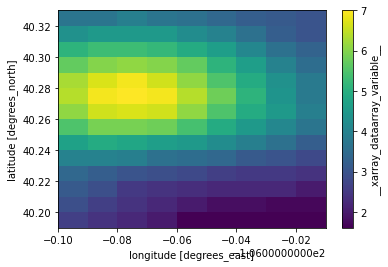

In [17]:
file = r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Precipitation\clipped_data.nc"
import netCDF4 as nc
import xarray as xr

def print_netcdf_info(file_path):
    """
    Print basic information of a NetCDF file including its dimensions, variables, and global attributes.

    Parameters:
    file_path (str): Path to the NetCDF file.
    """
    # Open the NetCDF file
    ds = nc.Dataset(file_path, 'r')

    print("NetCDF File Information:")
    print("------------------------")
    
    # Print global attributes
    print("Global attributes:")
    for attr_name in ds.ncattrs():
        print(f"{attr_name}: {ds.getncattr(attr_name)}")
    print()

    # Print dimensions
    print("Dimensions:")
    for dim_name, dim in ds.dimensions.items():
        print(f"{dim_name}: length {len(dim)}, unlimited={dim.isunlimited()}")
    print()
    
    # Print variables and details
    print("Variables:")
    for var_name, var in ds.variables.items():
        print(f"{var_name}: {var.dimensions}, type={var.dtype}")
        # Print variable attributes
        for attr_name in var.ncattrs():
            print(f"    {attr_name}: {var.getncattr(attr_name)}")
    print()

    # Close the NetCDF file
    ds.close()

import xarray as xr

def print_first_four_grid_points(file_path):
    """
    Print the first four data entries for a variable in a NetCDF file. Lists all variables if the specified one is not found.

    Parameters:
    file_path (str): Path to the NetCDF file.
    """
    # Open the NetCDF file as an xarray Dataset
    try:
        ds = xr.open_dataset(file_path)
        print("Available variables in the dataset:")
        for var in ds.variables:
            print(var)
        
        # Specify the variable name here if it's static, or pass it as a function argument if it varies
        variable_name = '__xarray_dataarray_variable__'
        time_var = 'time'
        # Check if the variable exists
        if variable_name in ds.data_vars:
            #make an array of the max value of each time step
            max_data = ds[variable_name].max(time_var)
        else:
            print(f"Variable '{variable_name}' not found in the dataset.")
        
    except FileNotFoundError:
        print("File not found. Please check the file path.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Close the dataset
        ds.close()
    return max_data


# Example usage
max_data = print_first_four_grid_points(file)

print(max_data)
#plot max data
import matplotlib.pyplot as plt
max_data.plot()


In [21]:
import pygrib
import requests
from bs4 import BeautifulSoup
import os
from datetime import datetime, timedelta
from tqdm import tqdm  # Import tqdm

def generate_date_range(start_date, end_date):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    date_range = [start + timedelta(days=x) for x in range(0, (end-start).days + 1)]
    return date_range

def construct_urls(base_url, date_range):
    urls = []
    for date in date_range:
        year = date.strftime("%Y")
        month = date.strftime("%m")
        day = date.strftime("%d")
        url = f"{base_url}{year}/{month}/{day}/mrms/ncep/MultiSensor_QPE_01H_Pass2/"
        #url = f"{base_url}{year}/{month}/{day}/mrms/ncep/GaugeCorr_QPE_01H/"
        urls.append(url)
    return urls

def download_files_from_url(url, download_dir):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check for HTTP errors
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find all .grib2.gz links and store in list
        files = [link.get('href') for link in soup.find_all('a') if link.get('href') and link.get('href').endswith('.grib2.gz')]
        date = url.split('/')[-7:-4]
        date =f"{date[0]}-{date[1]}-{date[2]}"
        for file_name in tqdm(files, desc=f"Downloading hourly data for {date}", leave=False):
            file_url = url + file_name
            file_response = requests.get(file_url)
            file_response.raise_for_status()
            
            filename = os.path.join(download_dir, file_name.split('/')[-1])
            with open(filename, 'wb') as file:
                file.write(file_response.content)
            #print(f"Downloaded {filename}")
    except requests.exceptions.HTTPError as err:
        print(f"HTTP Error: {err}")
    except Exception as e:
        print(f"Error: {e}")

def read_grib2_file(filepath):
    grbs = pygrib.open(filepath)
    for grb in grbs:
        print(grb)
        data = grb.values
    grbs.close()

start_date = '2022-05-01'
end_date = '2022-10-31'
download_dir = r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Precipitation\MRMS Data\2022"
base_url = 'https://mtarchive.geol.iastate.edu/'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

date_range = generate_date_range(start_date, end_date)
urls = construct_urls(base_url, date_range)

for url in tqdm(urls, desc=f"Downloading hourly data for date range {start_date} to {end_date}"):
    download_files_from_url(url, download_dir)





